In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = np.array(concrete_compressive_strength.data.features )
y = np.array(concrete_compressive_strength.data.targets) 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'published_in': 'Cement and Concrete Res

In [2]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# split test to calibration and test
X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

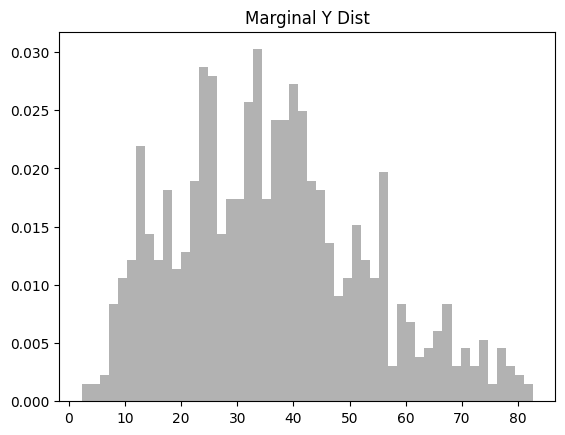

In [3]:
import matplotlib.pyplot as plt

# Get Y Centers
plt.figure()
plt.title("Marginal Y Dist")
Y_bin_count = 50
Y_hist = plt.hist(y_train, bins=Y_bin_count, density=True, alpha=0.6, color='gray', label='Data')
y_train_digital_labels = np.fmin(np.digitize(y_train, Y_hist[1]), Y_bin_count)
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
proto_centers = moving_average(Y_hist[1], n=2)

In [4]:
X_cal.shape

(103, 8)

In [5]:
import torch

def get_cuda_summary(memory=False):
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('CUDA is not available')

# Check CUDA summary
get_cuda_summary()

# Set up device
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device = torch.device('cuda:1')  # Prefer cuda:1 if available
    else:
        device = torch.device('cuda:0')  # Fallback to cuda:0 if only one CUDA device is available
else:
    device = torch.device('cpu')  # Fallback to CPU if CUDA is not available

torch.cuda.set_device(device) if torch.cuda.is_available() else None

print(f"Using device: {device}")


CUDA device =  NVIDIA TITAN RTX
Available number of devices =  1
Device numbers              =  [0]
Current device              =  0
Using device: cuda:0


In [6]:
from torch import nn
import torch 



class ConditionalClassifier(nn.Module):
    def __init__(self, in_size = 8, no_of_classes=50):
        super(ConditionalClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [19]:
model = ConditionalClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
train_x = torch.tensor(X_train).to(torch.float).to(device)
train_y = torch.tensor(y_train_digital_labels-1, dtype=torch.long).to(device)

In [20]:
losses = []
torch.manual_seed(0)
for step in range(5000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y.flatten())
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        # Add acc
        pass

epoch 1 loss=3.921
epoch 100 loss=2.867
epoch 200 loss=2.206
epoch 300 loss=1.641
epoch 400 loss=1.177
epoch 500 loss=0.8354
epoch 600 loss=0.6029
epoch 700 loss=0.4489
epoch 800 loss=0.3468
epoch 900 loss=0.2773
epoch 1000 loss=0.2278
epoch 1100 loss=0.1912
epoch 1200 loss=0.163
epoch 1300 loss=0.1408
epoch 1400 loss=0.1228
epoch 1500 loss=0.1083
epoch 1600 loss=0.09641
epoch 1700 loss=0.08661
epoch 1800 loss=0.07841
epoch 1900 loss=0.07153
epoch 2000 loss=0.06564
epoch 2100 loss=0.06068
epoch 2200 loss=0.05643
epoch 2300 loss=0.05273
epoch 2400 loss=0.04951
epoch 2500 loss=0.04669
epoch 2600 loss=0.04422
epoch 2700 loss=0.04207
epoch 2800 loss=0.04017
epoch 2900 loss=0.03846
epoch 3000 loss=0.03693
epoch 3100 loss=0.03555
epoch 3200 loss=0.03434
epoch 3300 loss=0.0332
epoch 3400 loss=0.03216
epoch 3500 loss=0.0312
epoch 3600 loss=0.03033
epoch 3700 loss=0.02953
epoch 3800 loss=0.02879
epoch 3900 loss=0.02812
epoch 4000 loss=0.02748
epoch 4100 loss=0.02688
epoch 4200 loss=0.02634
epoc

In [ ]:
losses = []
torch.manual_seed(0)
for step in range(5000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y.flatten())
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

In [21]:

import torch
import numpy as np
import torch.nn.functional as F

train_x = torch.tensor(X_cal).to(torch.float).to(device)
train_y = torch.tensor(y_train_digital_labels-1, dtype=torch.long).to(device)

# yüzde kaç covarage istiyoz 

for alpha in [0.1,0.5,0.9]:
# alpha = 0.9

    model.eval()
    with torch.no_grad():
        cal_logits = model(cal_x)
        cal_probs = F.softmax(cal_logits, dim=1)
        true_class_probs = [cal_probs[i,cal_y[i]].cpu().item() for i in range(cal_probs.size(0))] 
        true_class_probs = np.array(true_class_probs)
        # sort 
        sorted_true_class_probs = np.sort(true_class_probs)
        p_score = np.quantile(sorted_true_class_probs, 1-alpha)
        
    # Ensure the model is in evaluation mode
    model.eval()



    # Feed the input tensor with value 0
    input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

    # Generate model predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        output_logits = model(input_tensor)

    # Apply softmax to get the probability distribution over the output classes
    # calculate_covarage
    output_probs = torch.softmax(output_logits, dim=1).squeeze(0).cpu().numpy()
    output_probs[output_probs > p_score] = 1
    output_probs[output_probs < p_score] = 0


    number_of_true = 0
    for true_class in test_y:
        number_of_true += output_probs[true_class]
            
    # covarage = number_of_true / all sample number 

    covarage = number_of_true / test_y.size(0)


    output_probs_grid = output_probs.reshape(50, 50)

    # how many of the goes in the area 


    # Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
    x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
    y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

    print(f"covarage = {covarage * 100}") 
    one_square_area = (x_edges - np.roll(x_edges,1))[1] * (y_edges - np.roll(y_edges,1))[1]
    pinaw = (output_probs == 1).sum() * one_square_area
    print(f"pinaw = {pinaw}")

    # Plot the probability distribution over the 2D grid using the bin edges
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

    # Get the colormap and set the color for under 0 values
    cmap = plt.get_cmap('viridis')

    # Set vmin to 0 to make sure the zero probability regions are colored
    im = ax.imshow(output_probs_grid, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
                origin='lower', cmap=cmap, vmin=0, vmax=output_probs_grid.max())

    # Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
    ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

    # Set the xlim and ylim with no extra background
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)

    # Add the colorbar and labels
    plt.colorbar(im, ax=ax, label='Probability')
    plt.title('Probability Distribution over the 2D Space')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Display proto centers
    xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
    plt.scatter(xx.flatten(), yy.flatten(), marker='x', c='red', s=0.1)
    plt.show()


(50,)